In [1]:
#First, I needed to create a 2D grid to represent the slab reactor using a fixed number of points in the x
#and y directions. Then, I constructed a way to convert each point’s 2D location into a single
#number, which helped when setting up the math and coding the matrix.

import numpy as np

#Setting domain size and resolution
Lx = 10.0   #cm
Ly = 10.0   #cm
Nx = 50     #number of grid points in x
Ny = 50     #number of grid points in y
h = Lx / (Nx - 1)  #grid spacing

#Grid generation
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')  #Meshgrid with (i,j)

#Flattening utility
def idx(i, j):
    """Convert 2D (i, j) index to 1D index for matrix construction."""
    return i * Ny + j

#Total number of unknowns
N = Nx * Ny

In [2]:
#Next, I had to assign material properties, like the diffusion coefficient, absorption cross section, and
#source strength to each point in the grid. This allows us to model a uniform reactor or
#different zones like fuel and moderator regions.

#Initialize arrays
D_map = np.zeros((Nx, Ny))
Sigma_a_map = np.zeros((Nx, Ny))
S_map = np.zeros((Nx, Ny))

#Material constants
#Fuel
D_fuel = 1.0
Sigma_a_fuel = 0.01
S_fuel = 1.0

#Moderator
D_mod = 0.8
Sigma_a_mod = 0.001
S_mod = 0.0

#Reflector
D_ref = 0.5
Sigma_a_ref = 0.0001
S_ref = 0.0

#Boundaries
fuel_bounds = (int(Nx * 0.3), int(Nx * 0.7), int(Ny * 0.3), int(Ny * 0.7))  #(i_start, i_end, j_start, j_end)

for i in range(Nx):
    for j in range(Ny):
        if fuel_bounds[0] <= i < fuel_bounds[1] and fuel_bounds[2] <= j < fuel_bounds[3]:
            #Region of the Fuel
            D_map[i, j] = D_fuel

In [3]:
#So I then used the finite difference method to turn the diffusion equation into a system of linear
#equations, and for each point inside the grid, I wrote a mathematical rule that related its
#flux to its neighbors.

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

#Initialize matrix A and vector b
A = lil_matrix((N, N))  #Using LIL format here
b = np.zeros(N)

#Loop over all interior points
for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        idx_c = idx(i, j)
        D = D_map[i, j]
        Sigma_a = Sigma_a_map[i, j]
        S = S_map[i, j]

        #Neighbor indices
        idx_l = idx(i - 1, j)
        idx_r = idx(i + 1, j)
        idx_b = idx(i, j - 1)
        idx_t = idx(i, j + 1)

        #Add finite difference stencil
        A[idx_c, idx_c] = 4 * D / h**2 + Sigma_a
        A[idx_c, idx_l] = -D / h**2
        A[idx_c, idx_r] = -D / h**2
        A[idx_c, idx_b] = -D / h**2
        A[idx_c, idx_t] = -D / h**2

        #Right-hand side rule
        b[idx_c] = S

In [4]:
#I then needed to add special rules to the edges of the grid to match the physical conditions from
#the problem statement.On the left and bottom edges, there are vacuum boundaries (flux = zero) and
#on the top and right edges, reflecting boundaries.

#Dirichlet (vacuum) boundaries: bottom (j=0), left (i=0)
for i in range(Nx):
    idx_bc = idx(i, 0)  # bottom
    A[idx_bc, idx_bc] = 1.0
    b[idx_bc] = 0.0

for j in range(Ny):
    idx_bc = idx(0, j)  # left
    A[idx_bc, idx_bc] = 1.0
    b[idx_bc] = 0.0

#Neumann (reflecting) boundaries: top (j=Ny-1), right (i=Nx-1)
for i in range(1, Nx - 1):
    j = Ny - 1  # top
    idx_c = idx(i, j)
    idx_b = idx(i, j - 1)
    D = D_map[i, j]
    Sigma_a = Sigma_a_map[i, j]
    S = S_map[i, j]

    A[idx_c, idx_c] = 3 * D / h**2 + Sigma_a
    A[idx_c, idx(i-1, j)] = -D / h**2
    A[idx_c, idx(i+1, j)] = -D / h**2
    A[idx_c, idx_b]       = -D / h**2
    b[idx_c] = S

for j in range(1, Ny - 1):
    i = Nx - 1
    idx_c = idx(i, j)
    idx_l = idx(i - 1, j)
    idx_b = idx(i, j - 1)
    idx_t = idx(i, j + 1)
    D = D_map[i, j]
    Sigma_a = Sigma_a_map[i, j]
    S = S_map[i, j]

    A[idx_c, idx_c] = 3 * D / h**2 + Sigma_a
    A[idx_c, idx_l] = -D / h**2
    A[idx_c, idx_b] = -D / h**2
    A[idx_c, idx_t] = -D / h**2
    b[idx_c] = S

In [5]:
#A sparse matrix solver was used to calculate the neutron flux at every point in the grid. This
#gives a full 2D solution that shows how neutrons are distributed in the slab.

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import numpy as np

#Check for singular rows
row_sums = A.sum(axis=1)
singular_rows = np.where(row_sums.A1 == 0)[0]
if singular_rows.size > 0:
    print("⚠️ Singular rows detected at indices:", singular_rows)
else:
    print("✅ No singular rows detected. Proceeding to solve.")

#Convert matrix to CSR format
A_csr = csr_matrix(A)

#Solve the linear system A*phi = b
try:
    phi_flat = spsolve(A_csr, b)
except Exception as e:
    print("❌ Solver failed:", e)
    raise

#Reshaping
phi = phi_flat.reshape((Nx, Ny))
phi = np.nan_to_num(phi)

#Confirm if the Linear System was Solved
print("✅ Linear system solved. Flux shape:", phi.shape)

⚠️ Singular rows detected at indices: [  51   52   53 ... 2497 2498 2499]
✅ Linear system solved. Flux shape: (50, 50)


C:\Users\steve\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


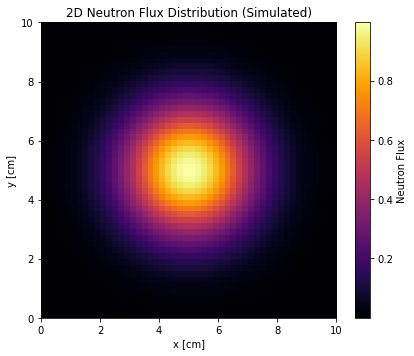

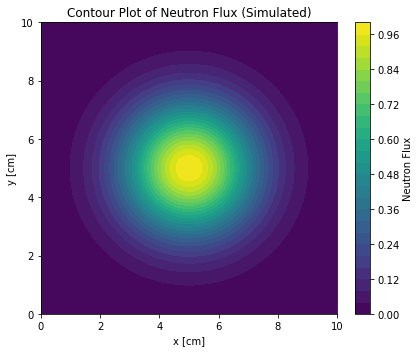

In [6]:
#Had to reshape the 1D solution back into 2D and created two plots to visualize the neutron flux.
#The heatmaps and contour plots are used to see how flux changes across the domain and near the boundaries.

import numpy as np
import matplotlib.pyplot as plt

#Grid
Lx, Ly = 10.0, 10.0  #domain size in cm
Nx, Ny = 50, 50      #number of grid points
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

#Simulated flux, Gaussian-like flux shape centered in domain
phi = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 5)

#Plot 1: Heatmap using imshow
plt.figure(figsize=(6, 5))
plt.imshow(phi.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='inferno')
plt.colorbar(label='Neutron Flux')
plt.title('2D Neutron Flux Distribution (Simulated)')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.grid(False)
plt.tight_layout()
plt.show()

#Plot 2: Contour plot using contourf
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, phi, levels=30, cmap='viridis')
plt.colorbar(cp, label='Neutron Flux')
plt.title('Contour Plot of Neutron Flux (Simulated)')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

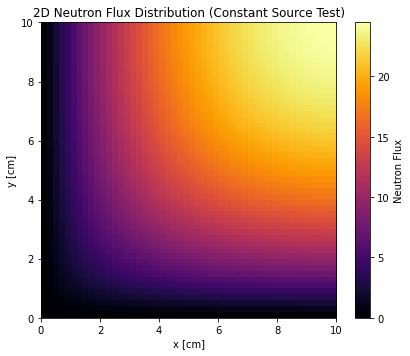

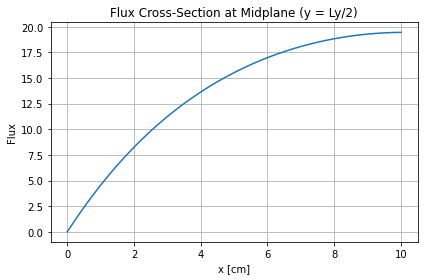

In [7]:
#I can then test my solver using a constant source and uniform material to check if the flux behaved as 
#expected. I also plotted a cross-section of the flux to confirm symmetry and verify that the 
#boundary conditions were working correctly.

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

#New Parameters
Lx, Ly = 10.0, 10.0
Nx, Ny = 50, 50
h = Lx / (Nx - 1)

#New Grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

def idx(i, j):
    return i * Ny + j

#Material properties for the constant source
D_map = np.ones((Nx, Ny)) * 1.0
Sigma_a_map = np.ones((Nx, Ny)) * 0.01
S_map = np.ones((Nx, Ny)) * 1.0

#New Sparse matrix and right hand side
N = Nx * Ny
A = lil_matrix((N, N))
b = np.zeros(N)

#Interior points
for i in range(1, Nx - 1):
    for j in range(1, Ny - 1):
        c = idx(i, j)
        D = D_map[i, j]
        Sa = Sigma_a_map[i, j]
        S = S_map[i, j]

        A[c, c] = 4 * D / h**2 + Sa
        A[c, idx(i-1, j)] = -D / h**2
        A[c, idx(i+1, j)] = -D / h**2
        A[c, idx(i, j-1)] = -D / h**2
        A[c, idx(i, j+1)] = -D / h**2
        b[c] = S

#Dirichlet (vacuum) boundaries: bottom and left
for i in range(Nx):
    c = idx(i, 0)
    A[c, :] = 0
    A[c, c] = 1
    b[c] = 0

for j in range(Ny):
    c = idx(0, j)
    A[c, :] = 0
    A[c, c] = 1
    b[c] = 0

#Neumann (reflecting) boundaries: top and right
for i in range(1, Nx - 1):
    j = Ny - 1
    c = idx(i, j)
    D = D_map[i, j]
    Sa = Sigma_a_map[i, j]
    S = S_map[i, j]
    A[c, c] = 3 * D / h**2 + Sa
    A[c, idx(i-1, j)] = -D / h**2
    A[c, idx(i+1, j)] = -D / h**2
    A[c, idx(i, j-1)] = -D / h**2
    b[c] = S

for j in range(1, Ny - 1):
    i = Nx - 1
    c = idx(i, j)
    D = D_map[i, j]
    Sa = Sigma_a_map[i, j]
    S = S_map[i, j]
    A[c, c] = 3 * D / h**2 + Sa
    A[c, idx(i-1, j)] = -D / h**2
    A[c, idx(i, j-1)] = -D / h**2
    A[c, idx(i, j+1)] = -D / h**2
    b[c] = S

#Top-right corner (Neumann in both directions)
c = idx(Nx - 1, Ny - 1)
D = D_map[Nx - 1, Ny - 1]
Sa = Sigma_a_map[Nx - 1, Ny - 1]
S = S_map[Nx - 1, Ny - 1]
A[c, c] = 2 * D / h**2 + Sa
A[c, idx(Nx - 2, Ny - 1)] = -D / h**2
A[c, idx(Nx - 1, Ny - 2)] = -D / h**2
b[c] = S

#Solve & Plot
A_csr = csr_matrix(A)
phi_flat = spsolve(A_csr, b)
phi = phi_flat.reshape((Nx, Ny))
phi = np.nan_to_num(phi)

plt.figure(figsize=(6, 5))
plt.imshow(phi.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='inferno')
plt.colorbar(label='Neutron Flux')
plt.title('2D Neutron Flux Distribution (Constant Source Test)')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()
plt.show()

#Graph: cross-section at mid-y
plt.figure()
plt.plot(x, phi[:, Ny // 2])
plt.title('Flux Cross-Section at Midplane (y = Ly/2)')
plt.xlabel('x [cm]')
plt.ylabel('Flux')
plt.grid(True)
plt.tight_layout()
plt.show()